# Stpe-2 Training

In [9]:
%reset

import numpy as np
import os
import keras
import pydot
import pandas as pd

from keras import Model, optimizers
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import multi_gpu_model, plot_model, to_categorical
from keras.applications.vgg16 import VGG16

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 1. Load Train Data

In [6]:
# Load Train Data(with regions)
train_data = np.load('train_data.npz')
print(train_data.files)

['cls_trn_img', 'cls_trn_lb', 'reg_trn_img', 'reg_trn_delta']


### 2. Data Augmenation

In [3]:
val_split = 0.2

cls_trn_img = train_data['cls_trn_img']
cls_trn_lb = to_categorical(train_data['cls_trn_lb'], 2)

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, validation_split=0.2)
train_datagen.fit(cls_trn_img)

# train-data
train_generator = train_datagen.flow(cls_trn_img, cls_trn_lb, batch_size=128, shuffle=True, subset='training')
# val-data
validation_generator = train_datagen.flow(cls_trn_img, cls_trn_lb, batch_size=128, shuffle=True, subset='validation')


### 3. Initialize Model

In [ ]:
# GPU Allocation Setting
    # import tensorflow as tf
    # from keras.backend.tensorflow_backend import set_session
    # config = tf.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = 0.9
    # config.gpu_options.visible_device_list = '0'
    # set_session(tf.Session(config=config))

vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    layers.trainable = False
    
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

model_final = Model(input = vggmodel.input, output = predictions)

# Multi GPU
# model_final = multi_gpu_model(model_final, gpus=2)

opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

### 4. Save Model

In [ ]:
# Model Save
model_json = model_final.to_json()
with open('network_model.json', 'w') as json_file:
    json_file.write(model_json)
# To Text File
with open('network_model.txt', 'w') as model_file:
    # Pass the file handle in as a lambda function to make it callable
    model_final.summary(print_fn=lambda x: model_file.write(x + '\n'))

# To Model Visualization
# plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 5. Model Training

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
log = CSVLogger('log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint(filepath='vgg16-airplane_{epoch:02d}_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
callback_list = [log, checkpoint, early]

history = model_final.fit_generator(
    train_generator,
    steps_per_epoch=int((cls_trn_img.shape[0] * (1.0 - 0.2)) / 128),
    epochs=1000,
    validation_data=validation_generator,
    validation_steps=int((cls_trn_img.shape[0] * 0.2) / 128),
    verbose=1,
    callbacks=callback_list)

model_final.save_weights('trained_weight.h5')

### 6. Loss&Accuracy Graph

In [112]:
import matplotlib.pyplot as plt

def VisualizeLossAccCurve(data):
    fig, loss_ax = plt.subplots(1, figsize=(10, 10))
    acc_ax = loss_ax.twinx()

    color_list = ['r', 'g', 'b', 'y']

    loss_ax.plot(data['loss'], color=color_list[0], linestyle='-', label='loss')
    acc_ax.plot(data['accuracy'], color=color_list[1], linestyle='-', label='accuracy')

    loss_ax.plot(data['val_loss'], color=color_list[2], linestyle=':', label='val_loss')
    acc_ax.plot(data['val_accuracy'], color=color_list[3], linestyle=':', label='val_accuracy')

    loss_ax.set_xlabel('Epoch')
    loss_ax.set_ylabel('Loss')
    acc_ax.set_ylabel('Accuracy')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    fig.suptitle('Training Results(Accuracy & Loss)', fontsize=16)

    plt.tight_layout()


data shape :: (109, 5)
data columns :: Index(['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object')


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.863659,0.322468,0.904018,0.213420
1,0,0.533499,7.404985,0.533333,7.618318
2,0,0.863368,0.450100,0.916583,0.207547
3,1,0.928268,0.195277,0.920953,0.226212
4,2,0.934238,0.181955,0.928770,0.204270
...,...,...,...,...,...
104,102,0.975320,0.067203,0.932300,0.365302
105,103,0.975597,0.065286,0.925996,0.575704
106,104,0.975400,0.064870,0.931795,0.468347
107,105,0.975086,0.066651,0.928139,0.576784


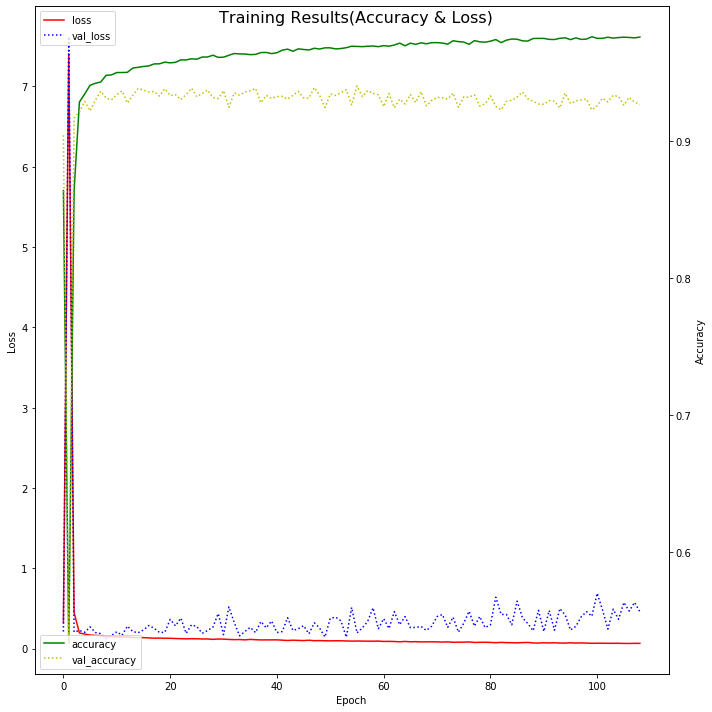

In [113]:
from IPython.display import display

# model 학습 종료된 파라미터 있을때.
# VisualizeLossAccCurve(history.history)

# 학습 log.csv file 읽어와서 사용 할 때
job_name = 'vgg16-airplane'
log_dir = os.path.join(os.getcwd(), 'experiments', job_name)
log_path = os.path.join(log_dir, 'log.csv')
data = pd.read_csv(log_path, sep=';')
print('data shape ::', data.shape)
print('data columns ::', data.columns)
display(pd.DataFrame(data))
data = data[['accuracy', 'loss', 'val_accuracy', 'val_loss']]

VisualizeLossAccCurve(data)